# **Kaggle Api Key**

In [ ]:
from google.colab import files

**To See How To Upload Kaggle Api Key , click on the link below**

https://christianjmills.com/posts/kaggle-obtain-api-key-tutorial/

In [ ]:
uploaded = files.upload()

Saving kaggle.json to kaggle (2).json


# **Run Main Programs**
To be run after all other sections

**These are to be run after all cell have been run in order**

In [ ]:
# function to convert the JavaScript object into an OpenCV image
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      display(x)
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,99,99),2)
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes
# @markdown Run Patient Supervision Program
print(Run)

In [ ]:
# @markdown Run Pneumonia Detector
# try image from other source
def pneumonia_detection ():
  # @markdown Enter Patient Name
  Patient_Name = "Manan" # @param {type:"string"}
  # @markdown Insert the image url of any pneumonia xray
  Insert_link_to_patient_xray = "https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg" # @param {type:"raw"}
  # @markdown Result will be shown below here ⬇️
  url_list = [
             # https://radiopaedia.org/cases/normal-chest-x-ray
             Insert_link_to_patient_xray
             ]


  for url in url_list:

   response = requests.get(url)
   # img = Image.open(BytesIO(response.content))
   img = load_img(BytesIO(response.content), target_size=(IMG_WIDTH, IMG_HEIGHT))
   img = img_to_array(img)
   img = np.expand_dims(img, axis=0)
   classes = model.predict(img, batch_size=10)
   print(classes[0][0])
   if classes[0][0]>0.5:
     print( Patient_Name + "\n Is PNEUMONIA case")
   else:
     print( Patient_Name + "\n Is NORMAL case")
pneumonia_detection()

1/1 [==============================] - 0s 24ms/step
1.0
Manan
 Is PNEUMONIA case


# **Importing and Loading Data , Importing Libraries and Making Partitions**




### Setting kaggle

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


### Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop

import requests
from io import BytesIO

import json
import zipfile

from random import sample
from datetime import datetime
from tqdm import tqdm, auto
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

### Load Data

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (PNEUMONIA/NORMAL). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [ ]:
# download dataset <owner>/<dataset-name>
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:29<00:00, 107MB/s] 
100% 2.29G/2.29G [00:29<00:00, 82.5MB/s]


In [ ]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zf:
  zf.extractall()

img_dir = os.path.join(os.getcwd(), 'chest_xray')
test_img_dir = os.path.join(img_dir, 'test')
train_img_dir = os.path.join(img_dir, 'train')
val_img_dir = os.path.join(img_dir, 'val')

### EDA

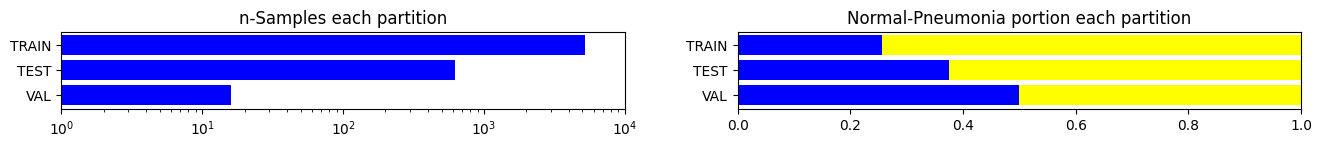

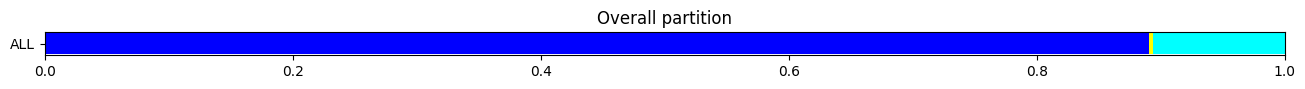

In [ ]:
#@title samples partition { display-mode: "form" }

NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

def chart_partitioning():

  fig = plt.figure(figsize=(16,1))

  ax = fig.add_subplot(1,2,1)
  ax.barh(['VAL'], [NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES], color='#0000ff')
  ax.set_xscale('log')
  ax.set_xlim((1,1e4))
  ax.set_title('n-Samples each partition');

  ax = fig.add_subplot(1,2,2)
  ax.barh(['VAL'], [NB_VAL_SAMPLES_N/NB_VAL_SAMPLES], color='#0000ff')
  ax.barh(['VAL'], [NB_VAL_SAMPLES_P/NB_VAL_SAMPLES], color='#ffff00',
          left=[NB_VAL_SAMPLES_N/NB_VAL_SAMPLES])
  ax.barh(['TEST'], [NB_TEST_SAMPLES_N/NB_TEST_SAMPLES], color='#0000ff')
  ax.barh(['TEST'], [NB_TEST_SAMPLES_P/NB_TEST_SAMPLES], color='#ffff00',
          left=[NB_TEST_SAMPLES_N/NB_TEST_SAMPLES])
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES], color='#0000ff')
  ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_P/NB_TRAIN_SAMPLES], color='#ffff00',
          left=[NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Normal-Pneumonia portion each partition');

  fig = plt.figure(figsize=(16,0.3))
  ax = fig.add_subplot(1,1,1)
  NB_TOTAL_SAMPLES = NB_TEST_SAMPLES + NB_TRAIN_SAMPLES + NB_VAL_SAMPLES
  ax.barh(['ALL'], [NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES], color='#0000ff')
  ax.barh(['ALL'], [NB_VAL_SAMPLES/NB_TOTAL_SAMPLES], color='#ffff00',
          left=[NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES])
  ax.barh(['ALL'], [NB_TEST_SAMPLES/NB_TOTAL_SAMPLES], color='#00ffff',
          left=[(NB_TRAIN_SAMPLES+NB_VAL_SAMPLES)/NB_TOTAL_SAMPLES])
  ax.set_xlim((0,1))
  ax.set_title('Overall partition');

chart_partitioning()

- Validation set too small, it caused high oscilation in the training process. Restructure train, val, test seems worthed, try **~80%, ~10%, ~10%** by moving some train samples to val.
- The imbalance class, there are mote pneumonia case in the dataset.

In [ ]:
# count how many samples to move so that train partition ~80%
train_part = NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES
n_to_move = round((train_part - 0.8) * NB_TRAIN_SAMPLES)
# count each n and p samples to move
# later train val have the same N/P proportion
n_to_move_N = round((NB_TRAIN_SAMPLES_N + NB_VAL_SAMPLES_N) /
                    (NB_TRAIN_SAMPLES + NB_VAL_SAMPLES) * n_to_move)
n_to_move_P = n_to_move - n_to_move_N

# move rendom files from one directory to other directory
def move_files_random(from_dir, to_dir, n):
  for filename in sample(os.listdir(from_dir), k=n):
    from_fpath = os.path.join(from_dir, filename)
    to_fpath = os.path.join(to_dir, filename)
    shutil.move(from_fpath, to_fpath)
  display(f"move {n} files from {from_dir} to {to_dir}")

move_files_random(from_dir=os.path.join(train_img_dir, 'NORMAL'),
                  to_dir=os.path.join(val_img_dir, 'NORMAL'),
                  n=n_to_move_N)

move_files_random(from_dir=os.path.join(train_img_dir, 'PNEUMONIA'),
                  to_dir=os.path.join(val_img_dir, 'PNEUMONIA'),
                  n=n_to_move_P)

'move 122 files from /content/chest_xray/train/NORMAL to /content/chest_xray/val/NORMAL'

'move 351 files from /content/chest_xray/train/PNEUMONIA to /content/chest_xray/val/PNEUMONIA'

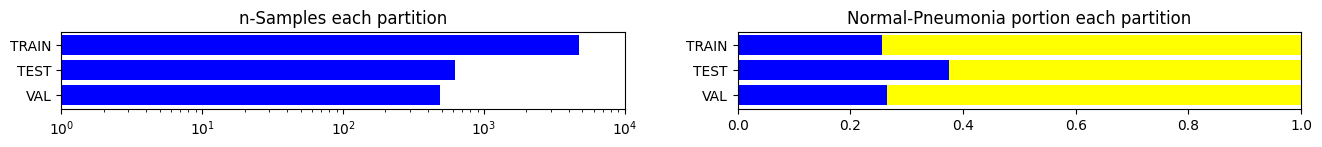

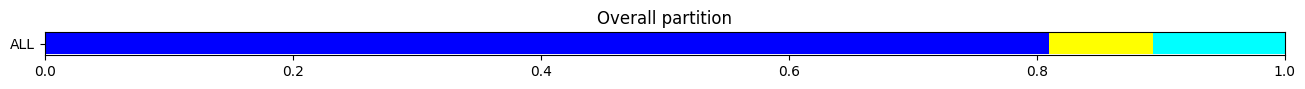

In [ ]:
#@title samples partition after restructure { display-mode: "form" }

NB_TRAIN_SAMPLES_N = len(os.listdir(os.path.join(train_img_dir, 'NORMAL')))
NB_TRAIN_SAMPLES_P = len(os.listdir(os.path.join(train_img_dir, 'PNEUMONIA')))
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P

NB_VAL_SAMPLES_N = len(os.listdir(os.path.join(val_img_dir, 'NORMAL')))
NB_VAL_SAMPLES_P = len(os.listdir(os.path.join(val_img_dir, 'PNEUMONIA')))
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

NB_TEST_SAMPLES_N = len(os.listdir(os.path.join(test_img_dir, 'NORMAL')))
NB_TEST_SAMPLES_P = len(os.listdir(os.path.join(test_img_dir, 'PNEUMONIA')))
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P

NB_TOTAL_SAMPLES = NB_TRAIN_SAMPLES + NB_VAL_SAMPLES + NB_TEST_SAMPLES

chart_partitioning()

- The current test set has different class proportion, not too different, and still can be assume are in the same distribution

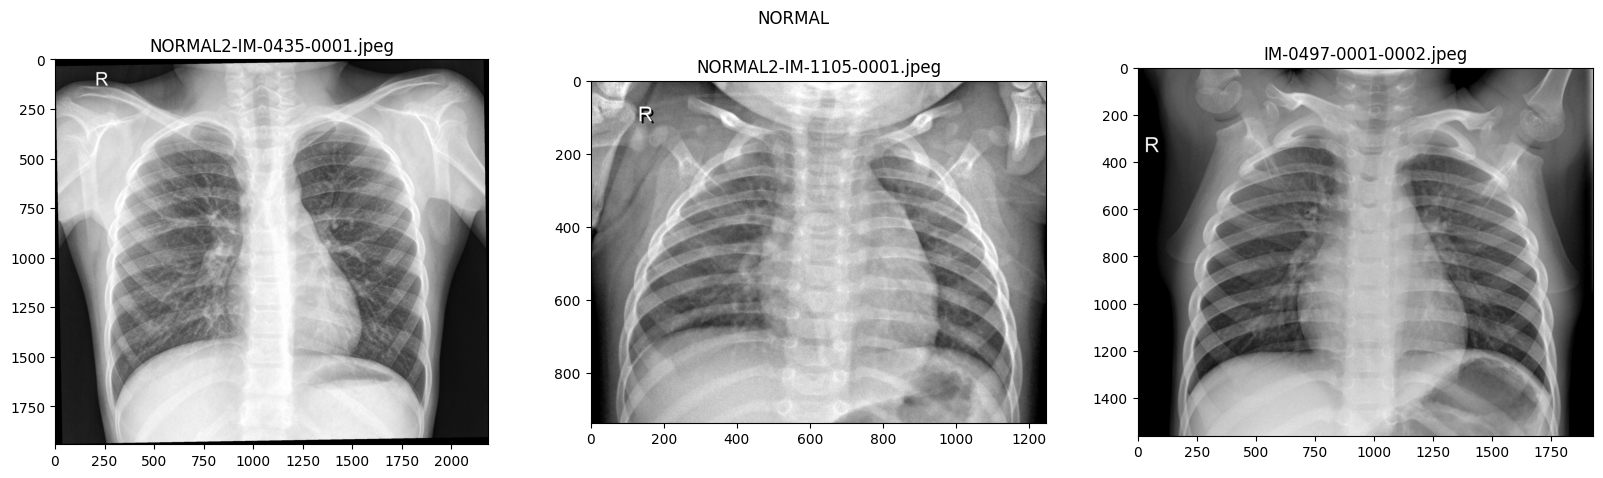

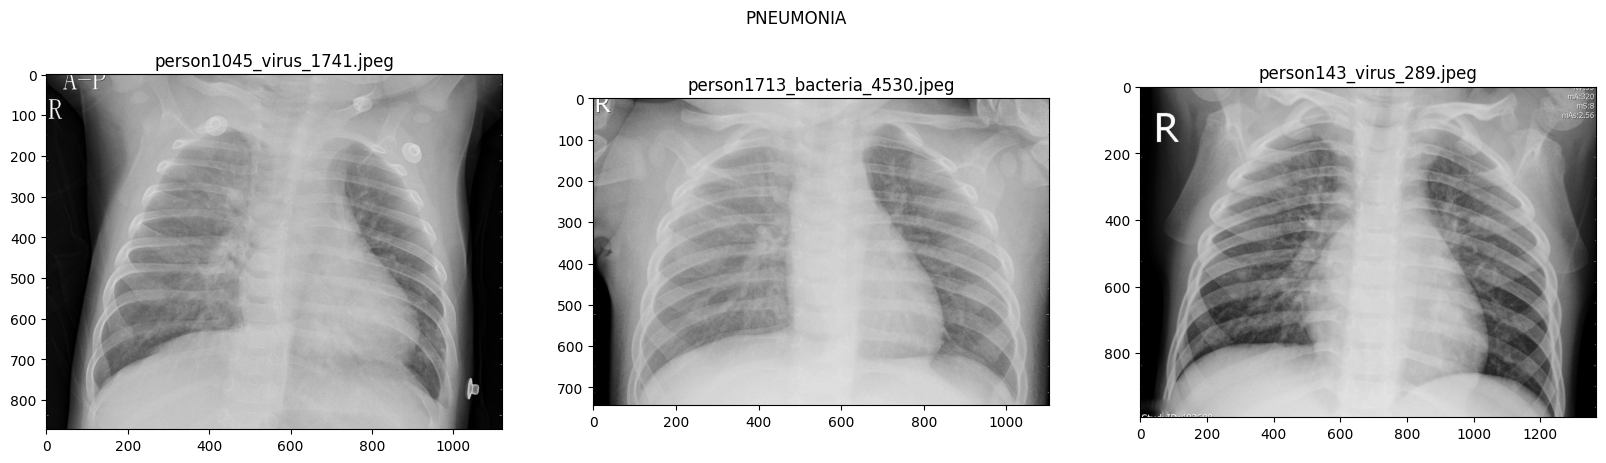

In [ ]:
#@title show some images { display-mode: "form" }

img_normal = []
img_pneumonia = []
for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'NORMAL')):
    for filename in filenames:
        img_normal.append(os.path.join(dirname, filename))
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'PNEUMONIA')):
    for filename in filenames:
        img_pneumonia.append(os.path.join(dirname, filename))

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax = ax.flatten()
plt.suptitle("NORMAL")
for i, j in enumerate(np.random.randint(len(img_normal), size=3).tolist()):
  ax[i].imshow(load_img(img_normal[j]))
  ax[i].set_title(img_normal[j].split('/')[-1]);

fig, ax = plt.subplots(1,3, figsize=(20, 5))
ax = ax.flatten()
plt.suptitle("PNEUMONIA")
for i, j in enumerate(np.random.randint(len(img_pneumonia), size=3).tolist()):
  ax[i].imshow(load_img(img_pneumonia[j]))
  ax[i].set_title(img_pneumonia[j].split('/')[-1]);

From the pictures, I can tell you there are differences in the rib cage shape of the patient who has pneumonia compared to normal chest.
- Somehow the x-ray return more clear image in normal person and foggy image in infected.
- Also, normal chest is relatively symetric between the right and the left part.

Know the case :
- When interpreting the x-ray, the radiologist will look for **white spots** in the lungs (called infiltrates) that identify an infection. This exam will also help determine if you have any complications related to pneumonia such as abscesses or pleural effusions (**fluid surrounding the lungs**).  [[source]](https://www.radiologyinfo.org/en/info.cfm?pg=pneumonia)
- Pneumonia is a very common disease. It can be either: 1) Bacterial pneumonia 2) Viral Pneumonia 3) Mycoplasma pneumonia and 4) Fungal pneumonia. This dataset consists pneumonia samples belonging to the first two classes.

>[Setting kaggle](#scrollTo=JT8aseCD3BVm)

>[Libraries](#scrollTo=6LznN37zOzyx)

>[Load Data](#scrollTo=DsiQ37BWcnTV)

>[EDA](#scrollTo=T8LQ9AGfOpL8)

>[Data Generator](#scrollTo=5ZRIri9xmIVI)

>[Create Model](#scrollTo=Rb-9DBfg3d-4)

>[Fit Model](#scrollTo=M1ylTPloJleq)

>[Evaluation](#scrollTo=wy5jT8e1NZth)

>>[Restart and re-run](#scrollTo=sNS_o5SKP-mr)



# Model Loader

Increase the **EPOCHS** size for more accuracy . Increasing Epochs will cause the model to take more time to be created

In [ ]:
#@title set epoch, batch_size { display-mode: "form" }

EPOCHS = 15 #@param {type:"slider", min:5, max:30, step:1}
BATCH_SIZE =  100#@param {type:"number"}

## **This Section Will Take alot of time to finish running . please be patient**

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 150, 150

train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=8,  # degrees
                   zoom_range=0.1,
                   width_shift_range=0.08,  # per cent width
                   height_shift_range=0.08,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.02,
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_img_dir,
                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary',
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow_from_directory(
                                val_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=BATCH_SIZE,
                                class_mode='binary',
                                )

test_generator = test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False,
                                class_mode='binary',
                                )

Found 4743 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


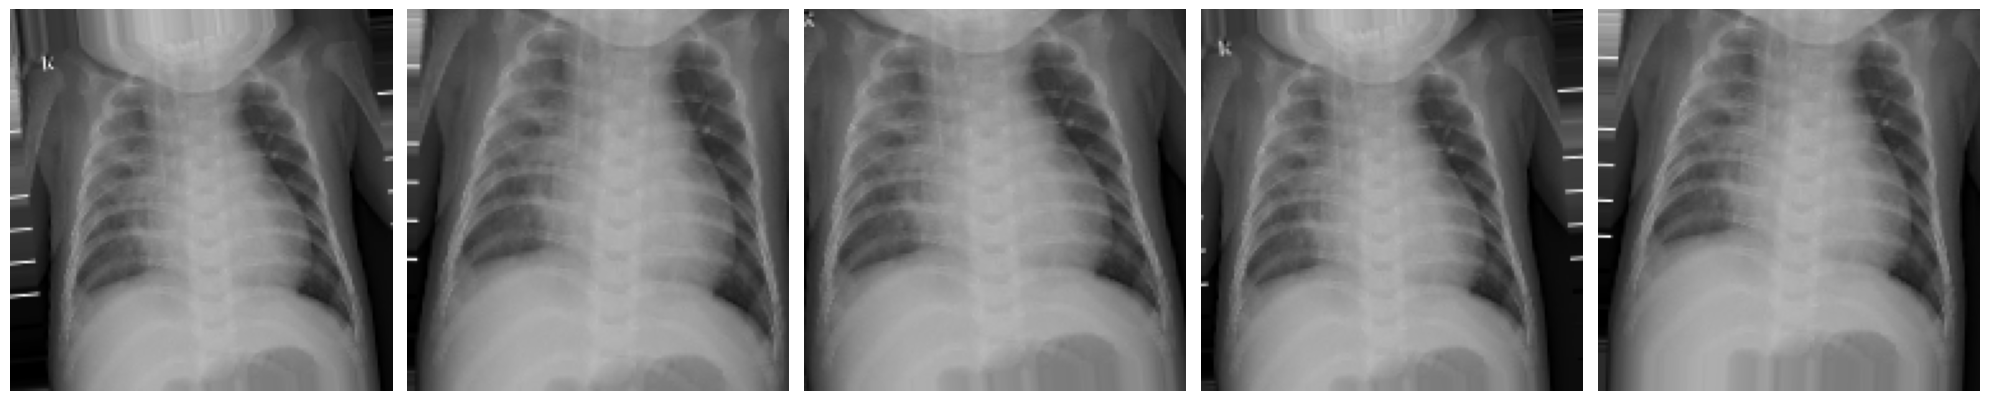

In [ ]:
#@title check posibilities of augmented images at training dataset { display-mode: "form" }

flow_n = 1 #@param {type:"slider", min:0, max:10, step:1}
idx_m = 10 #@param {type:"slider", min:0, max:99, step:1}

# This function will plot augmented images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show();

plotImages([train_generator[flow_n][0][idx_m] for i in range(5)])

- To resize the image so that all of the images have the same form: width of 150 and height of 150
- ImageDataGenerator augmentation might causes "bleeding" and crop important feature.
- It is crucial the chest area are fully included in the image. While in some images, the chest area is just fit so perfectly that even tiny slight parameter may crop them.

### Create Model

In [ ]:
#@title set optimizer and learning_rate{ display-mode: "form" }

optimizer = "RMSprop" #@param ["adam", "RMSprop"]
learning_rate = 0.008 #@param {type:"number"}

optimizer = Adam(learning_rate=learning_rate) if optimizer == "adam" \
              else RMSprop(learning_rate=learning_rate)

In [ ]:
inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu',
               input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Flatten()(model)
model = Dense(activation='relu', units=128)(model)
outputs = Dense(activation='sigmoid', units=1)(model)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 41472)             0     

In [ ]:
gc.collect()

20380

### Fit Model

In [ ]:
history = model.fit_generator(
                      train_generator,
                      steps_per_epoch=NB_TRAIN_SAMPLES//BATCH_SIZE+1,
                      epochs=EPOCHS,
                      validation_data=val_generator,
                      validation_steps=NB_VAL_SAMPLES//BATCH_SIZE+1,
                      # callbacks=,
                      )

Epoch 1/15
48/48 [==============================] - 69s 1s/step - loss: 9.5378 - accuracy: 0.7090 - val_loss: 0.6096 - val_accuracy: 0.7342
Epoch 2/15
48/48 [==============================] - 64s 1s/step - loss: 1.3675 - accuracy: 0.7012 - val_loss: 0.5816 - val_accuracy: 0.7342
Epoch 3/15
48/48 [==============================] - 69s 1s/step - loss: 1.0986 - accuracy: 0.7299 - val_loss: 0.5759 - val_accuracy: 0.7342
Epoch 4/15
48/48 [==============================] - 65s 1s/step - loss: 0.9892 - accuracy: 0.7206 - val_loss: 0.5090 - val_accuracy: 0.7260
Epoch 5/15
48/48 [==============================] - 63s 1s/step - loss: 0.9429 - accuracy: 0.7468 - val_loss: 0.4786 - val_accuracy: 0.7464
Epoch 6/15
48/48 [==============================] - 63s 1s/step - loss: 0.4239 - accuracy: 0.7957 - val_loss: 0.3898 - val_accuracy: 0.8057
Epoch 7/15
48/48 [==============================] - 63s 1s/step - loss: 1.0991 - accuracy: 0.7959 - val_loss: 0.3446 - val_accuracy: 0.8282
Epoch 8/15
48/48 [==

In [ ]:
score = model.evaluate(test_generator,
                       steps=NB_TEST_SAMPLES//32+1,
                       )

20/20 [==============================] - 5s 237ms/step - loss: 0.8346 - accuracy: 0.7676


In [ ]:
#@title save model and log { display-mode: "form" }

# save model
timestamp = datetime.strftime(datetime.now(), "%m%d_%H%m")  #month day hour min
model_fname = f"sequential_{timestamp}"; display(model_fname)
# model.save(model_fname, save_format='h5')

log = {}
log['history'] = history.history
log['score'] = {'loss':score[0], 'accuracy':score[1]}
log['params'] = {'epoch':EPOCHS, 'batch_size':BATCH_SIZE,
                 'optimizer':str(optimizer), 'learning_rate': learning_rate,
                 'loss':loss, 'metrics':str(metrics)}
log_fname = f"log_{timestamp}.json"; display(log_fname)

with open(log_fname, 'w') as f:
  json.dump(log, f)

### Evaluation

In [ ]:
#@title define functions: plot_metrics { display-mode: "form" }

import seaborn as sns
sns.set(style='whitegrid')

def plot_metrics(fp, is_url=True):

  if is_url!=True:
    log = json.load(open(fp, 'r'))
  else:
    response = requests.get(fp)
    log = response.json()

  acc = log['history']['accuracy']
  loss = log['history']['loss']
  val_acc = log['history']['val_accuracy']
  val_loss = log['history']['val_loss']

  fig = plt.figure(figsize=(12, 6))

  ax = fig.add_subplot(1,2,1)
  ax.plot(np.arange(1,len(acc)+1), acc, label='train_accuracy')
  ax.plot(np.arange(1,len(val_acc)+1), val_acc, label='val_accuracy')
  ax.legend(loc='lower right')
  ax.set_ylabel('Accuracy')
  ax.set_xlabel('Epoch #')
  ax.grid()

  ax = fig.add_subplot(1,2,2)
  ax.plot(np.arange(1,len(loss)+1), loss, label='train_loss')
  ax.plot(np.arange(1,len(val_loss)+1), val_loss, label='val_loss')
  ax.legend(loc='upper right')
  ax.set_ylabel('Loss')
  ax.set_xlabel('Epoch #')
  ax.yaxis.tick_right()
  ax.yaxis.set_label_position("right")
  ax.grid();

In [ ]:
#@title show result plot_metrics
url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/log/log_0405_0604.json'
plot_metrics(url, is_url=True)

In [ ]:
#@title show result plot_metrics
img_url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/image/cm_0405_0904.png'
response = requests.get(img_url)
load_img(BytesIO(response.content))

In [ ]:
#@title show result plot_metrics
url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/log/log_0405_0904.json'
plot_metrics(url, is_url=True)

In [ ]:
#@title show result plot_metrics
img_url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/image/cm_0405_1104.png'
response = requests.get(img_url)
load_img(BytesIO(response.content))

In [ ]:
#@title show result plot_metrics
url = 'https://raw.githubusercontent.com/fadheladlansyah/chest-xray-pneumonia/master/log/log_0405_1104.json'
plot_metrics(url, is_url=True)

---
Restart and re-run
---

In [ ]:
#@title confusion matrix on test dataset { display-mode: "form" }

import seaborn as sns
sns.set(style='whitegrid')

preds = model.predict(test_datagen.flow_from_directory(
                                test_img_dir,
                                target_size=(IMG_WIDTH, IMG_HEIGHT),
                                batch_size=32,
                                shuffle=False,
                                class_mode='binary'
                                ),
                      steps=NB_TEST_SAMPLES//32+1)

labels = np.vstack([np.zeros(shape=(NB_TEST_SAMPLES_N,1)),
                    np.ones(shape=(NB_TEST_SAMPLES_P,1))])

# Get the confusion matrix
cm  = tf.math.confusion_matrix(labels.flatten(), np.round(preds).flatten())
ax = sns.heatmap(cm.numpy(), annot=True, fmt="d")

In [ ]:
#@title show result plot_metrics
plot_metrics(log_fname, is_url=False)